In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
eeg_df = pd.read_csv("eeg_features_combined.csv")
social_df = pd.read_csv("cleaned_social_media_usage.csv")

In [3]:
social_features = ['Daily_Minutes_Spent', 'Posts_Per_Day', 'Likes_Per_Day', 'Follows_Per_Day','Engagement_Score']
scaler = StandardScaler()
social_scaled = scaler.fit_transform(social_df[social_features])

social_kmeans = KMeans(n_clusters=3, random_state=42)
social_df['Social_Cluster'] = social_kmeans.fit_predict(social_scaled)

In [4]:
eeg_features = ['Delta', 'Theta', 'Alpha', 'Beta']
eeg_scaled = scaler.fit_transform(eeg_df[eeg_features])

eeg_kmeans = KMeans(n_clusters=3, random_state=42)
eeg_df['EEG_Cluster'] = eeg_kmeans.fit_predict(eeg_scaled)

eeg_cluster_profiles = eeg_df.groupby('EEG_Cluster')[eeg_features].mean()


In [5]:
social_df['Composite_Engagement'] = (
    0.4 * social_df['Posts_Per_Day'] +
    0.3 * social_df['Likes_Per_Day'] +
    0.3 * social_df['Follows_Per_Day'] + 
    0.2 * social_df['Engagement_Score']
)

social_engagement_avg = social_df.groupby('Social_Cluster')['Composite_Engagement'].mean()

# Map Social Clusters to EEG Clusters via similarity (sort by avg activity)
sorted_social_clusters = social_engagement_avg.sort_values().index.tolist()
sorted_eeg_clusters = eeg_cluster_profiles.mean(axis=1).sort_values().index.tolist()
cluster_mapping = dict(zip(sorted_social_clusters, sorted_eeg_clusters))

# Assign EEG profile to social users
social_df['Mapped_EEG_Cluster'] = social_df['Social_Cluster'].map(cluster_mapping)
# Assign EEG profile to social users
social_df['Mapped_EEG_Cluster'] = social_df['Social_Cluster'].map(cluster_mapping)

social_df = social_df.join(
    social_df['Mapped_EEG_Cluster'].apply(lambda x: eeg_cluster_profiles.loc[x]).reset_index(drop=True),
    rsuffix='_EEG'
)




In [ ]:
correlation_df = social_df[
    ['Daily_Minutes_Spent', 'Posts_Per_Day', 'Likes_Per_Day', 'Follows_Per_Day','Engagement_Score'] + eeg_features
].corr()

print(cross_corr)
plt.figure(figsize=(10, 8))
print(correlation_df)
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Social Media Behavior and Mapped EEG Patterns")
plt.show()


NameError: name 'social_df' is not defined

In [ ]:
correlation_pairs = (
    correlation_df
    .unstack()
    .reset_index()
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
)

# Remove duplicates and self-correlations
correlation_pairs = correlation_pairs[correlation_pairs['Feature_1'] != correlation_pairs['Feature_2']]
correlation_pairs['AbsCorrelation'] = correlation_pairs['Correlation'].abs()
strong_pairs = correlation_pairs[correlation_pairs['AbsCorrelation'] > 0.5]

# Drop duplicates like (A, B) and (B, A)
strong_pairs = strong_pairs.sort_values(by='AbsCorrelation', ascending=False)
strong_pairs = strong_pairs.drop_duplicates(subset=['Correlation'])

print("🔍 Strong Correlation Pairs (|r| > 0.5):")
print(strong_pairs[['Feature_1', 'Feature_2', 'Correlation']])

🔍 Strong Correlation Pairs (|r| > 0.5):
           Feature_1            Feature_2  Correlation
79              Beta                Alpha     0.990865
69             Alpha                Theta     0.968967
22     Likes_Per_Day     Engagement_Score     0.962598
62             Theta                 Beta     0.926780
41  Engagement_Score                Delta     0.841764
23     Likes_Per_Day                Delta     0.827054
51             Delta                Theta     0.770312
58             Theta     Engagement_Score     0.679139
24     Likes_Per_Day                Theta     0.663168
68             Alpha                Delta     0.588780
72              Beta  Daily_Minutes_Spent    -0.582105
43  Engagement_Score                Alpha     0.534552
63             Alpha  Daily_Minutes_Spent    -0.527323
25     Likes_Per_Day                Alpha     0.520009


/tmp/ipykernel_322155/332190040.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")
/tmp/ipykernel_322155/332190040.py:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mrinalgaur/Desktop/DsProject/DsProject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


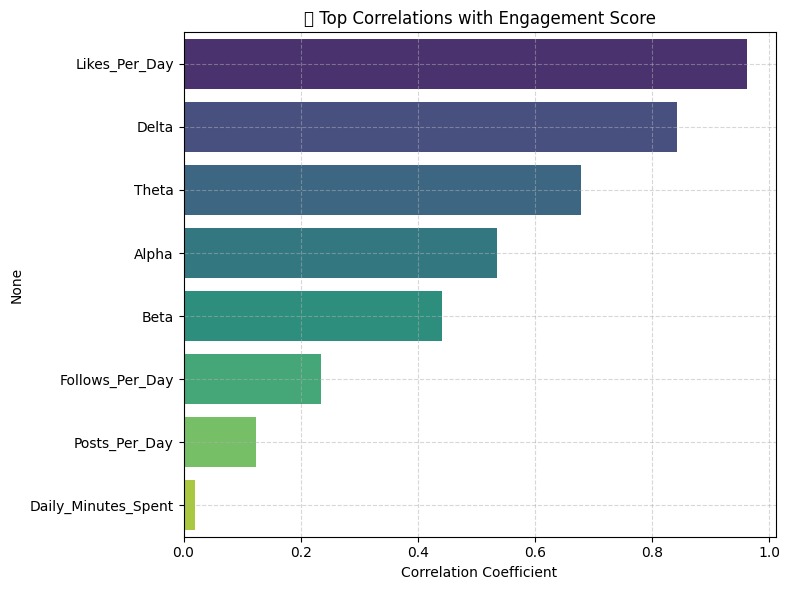

In [8]:
top_corr = correlation_df["Engagement_Score"].drop("Engagement_Score").sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")
plt.title("📈 Top Correlations with Engagement Score")
plt.xlabel("Correlation Coefficient")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_322155/3959482635.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mrinalgaur/Desktop/DsProject/DsProject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


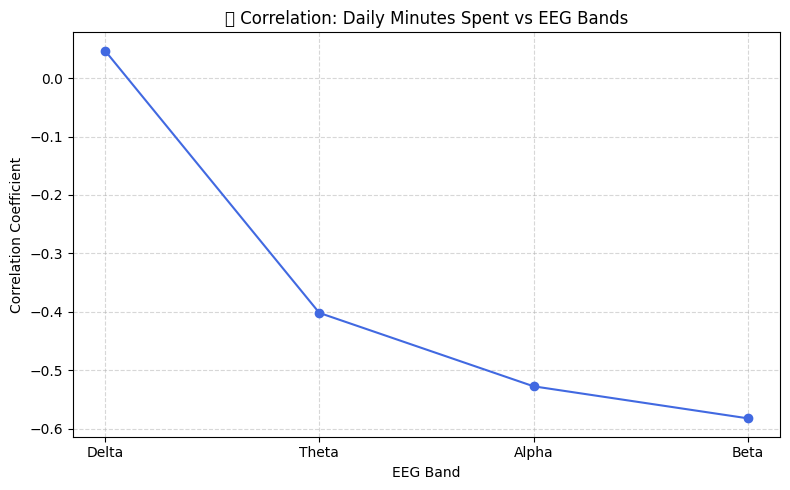

In [9]:

eeg_bands = ['Delta', 'Theta', 'Alpha', 'Beta']

correlations = correlation_df.loc['Daily_Minutes_Spent', eeg_bands]

plt.figure(figsize=(8, 5))
plt.plot(eeg_bands, correlations.values, marker='o', linestyle='-', color='royalblue')
plt.title("📉 Correlation: Daily Minutes Spent vs EEG Bands")
plt.xlabel("EEG Band")
plt.ylabel("Correlation Coefficient")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_233333/1832082596.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mrinalgaur/Desktop/DsProject/DsProject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


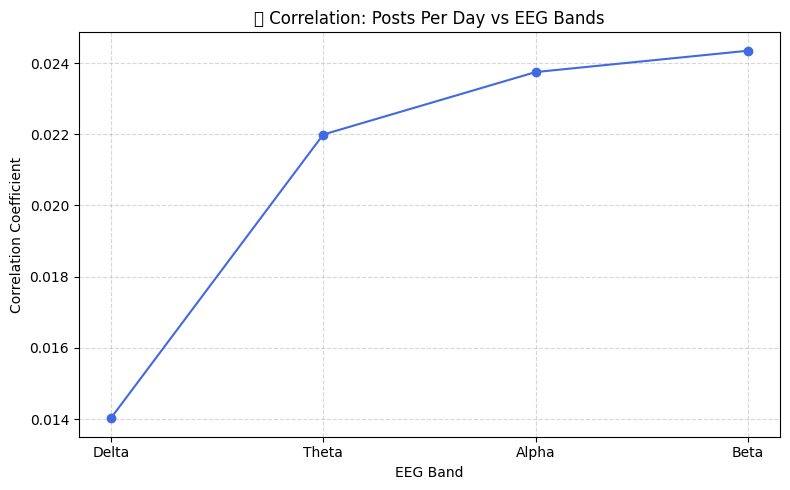

In [24]:

eeg_bands = ['Delta', 'Theta', 'Alpha', 'Beta']

correlations = correlation_df.loc['Posts_Per_Day', eeg_bands]

plt.figure(figsize=(8, 5))
plt.plot(eeg_bands, correlations.values, marker='o', linestyle='-', color='royalblue')
plt.title("📉 Correlation: Posts Per Day vs EEG Bands")
plt.xlabel("EEG Band")
plt.ylabel("Correlation Coefficient")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_233333/412690581.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mrinalgaur/Desktop/DsProject/DsProject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


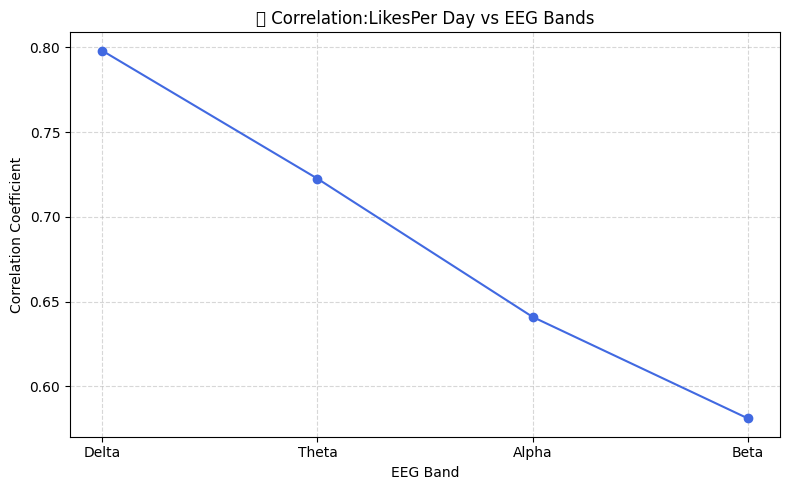

In [25]:

eeg_bands = ['Delta', 'Theta', 'Alpha', 'Beta']

correlations = correlation_df.loc['Likes_Per_Day', eeg_bands]

plt.figure(figsize=(8, 5))
plt.plot(eeg_bands, correlations.values, marker='o', linestyle='-', color='royalblue')
plt.title("📉 Correlation:LikesPer Day vs EEG Bands")
plt.xlabel("EEG Band")
plt.ylabel("Correlation Coefficient")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_233333/3023135220.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mrinalgaur/Desktop/DsProject/DsProject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


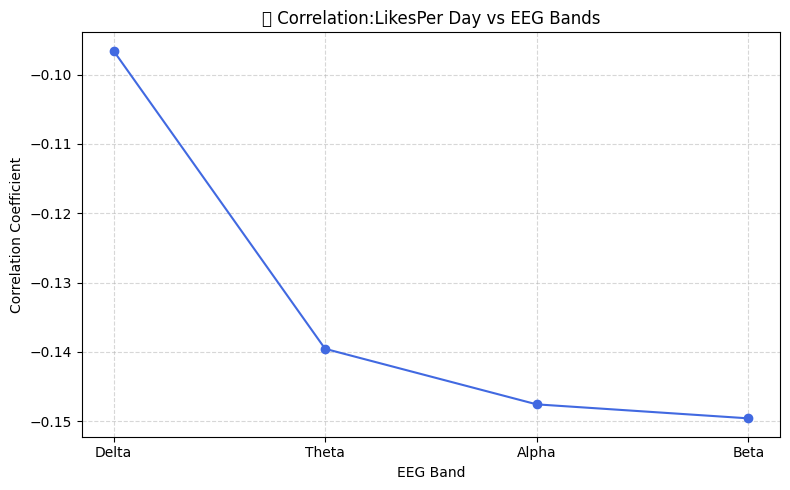

In [ ]:

eeg_bands = ['Delta', 'Theta', 'Alpha', 'Beta']

correlations = correlation_df.loc['Follows_Per_Day', eeg_bands]

plt.figure(figsize=(8, 5))
plt.plot(eeg_bands, correlations.values, marker='o', linestyle='-', color='royalblue')
plt.title("📉 Correlation:Follows Per Day vs EEG Bands")
plt.xlabel("EEG Band")
plt.ylabel("Correlation Coefficient")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
